In [1]:
from IPython.display import display, Markdown as md
from whr.imports import *

%load_ext autoreload
%autoreload 2
import whr
from whr import *

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

whr.setup_pytensor()

In [2]:
da = whr.PreprocessedData.load()
print(f'{len(da.games)} games; {len(da.gamePlayers)} gamePlayers; {len(da.playerDays)} playerDays')

22150 games; 300393 gamePlayers; 73858 playerDays


In [3]:
jointUnadjModel = whr.createUnadjustedCumsumMatrixModel(da).loadIData().loadMAP()
jointSimpleAdjModel = whr.createSimpleAdjustedModel(da).loadIData()
jointBPSTAdjModel = whr.createBPSTAdjustedModel(da).loadIData()

jointModels = dict(jointUnadjModel=jointUnadjModel,
                   jointSimpleAdjModel=jointSimpleAdjModel,
                   jointBPSTAdjModel=jointBPSTAdjModel)


In [4]:
unevenGamesData = da.restrictGames(da.games.winnerCount != da.games.loserCount, True)

In [5]:
(da.games.shape, da.playerDays.shape, unevenGamesData.games.shape, unevenGamesData.playerDays.shape)
# (da.gamePlayers.shape, unevenGames.gamePlayers.shape)

((22150, 20), (73858, 6), (7231, 20), (53355, 6))

In [6]:
# The fixed ratings used in the below models
unevenGamesMAPRatings : pd.DataFrame = jointUnadjModel.MAP_ratings.loc[unevenGamesData.playerDays.index, 'rating']
unevenGamesMeanRatings = jointUnadjModel.getMeanRatingsForPlayerDays(unevenGamesData.playerDays.index)

In [7]:
pdc = len(unevenGamesData.playerDays)
unevenGamesRatingIxLookup = pat.Series[int](range(pdc), index=unevenGamesData.playerDays.index)



In [8]:
frModels = whr.makeAllFixedRatingsModels(unevenGamesData, unevenGamesMeanRatings=unevenGamesMeanRatings, unevenGamesMAPRatings=unevenGamesMAPRatings)

In [9]:
if False:
    for m in frModels.values():
        m.sample(cores=16, draws=2000)
        m.saveIData()
else:
    for m in frModels.values():
        m.loadIData()


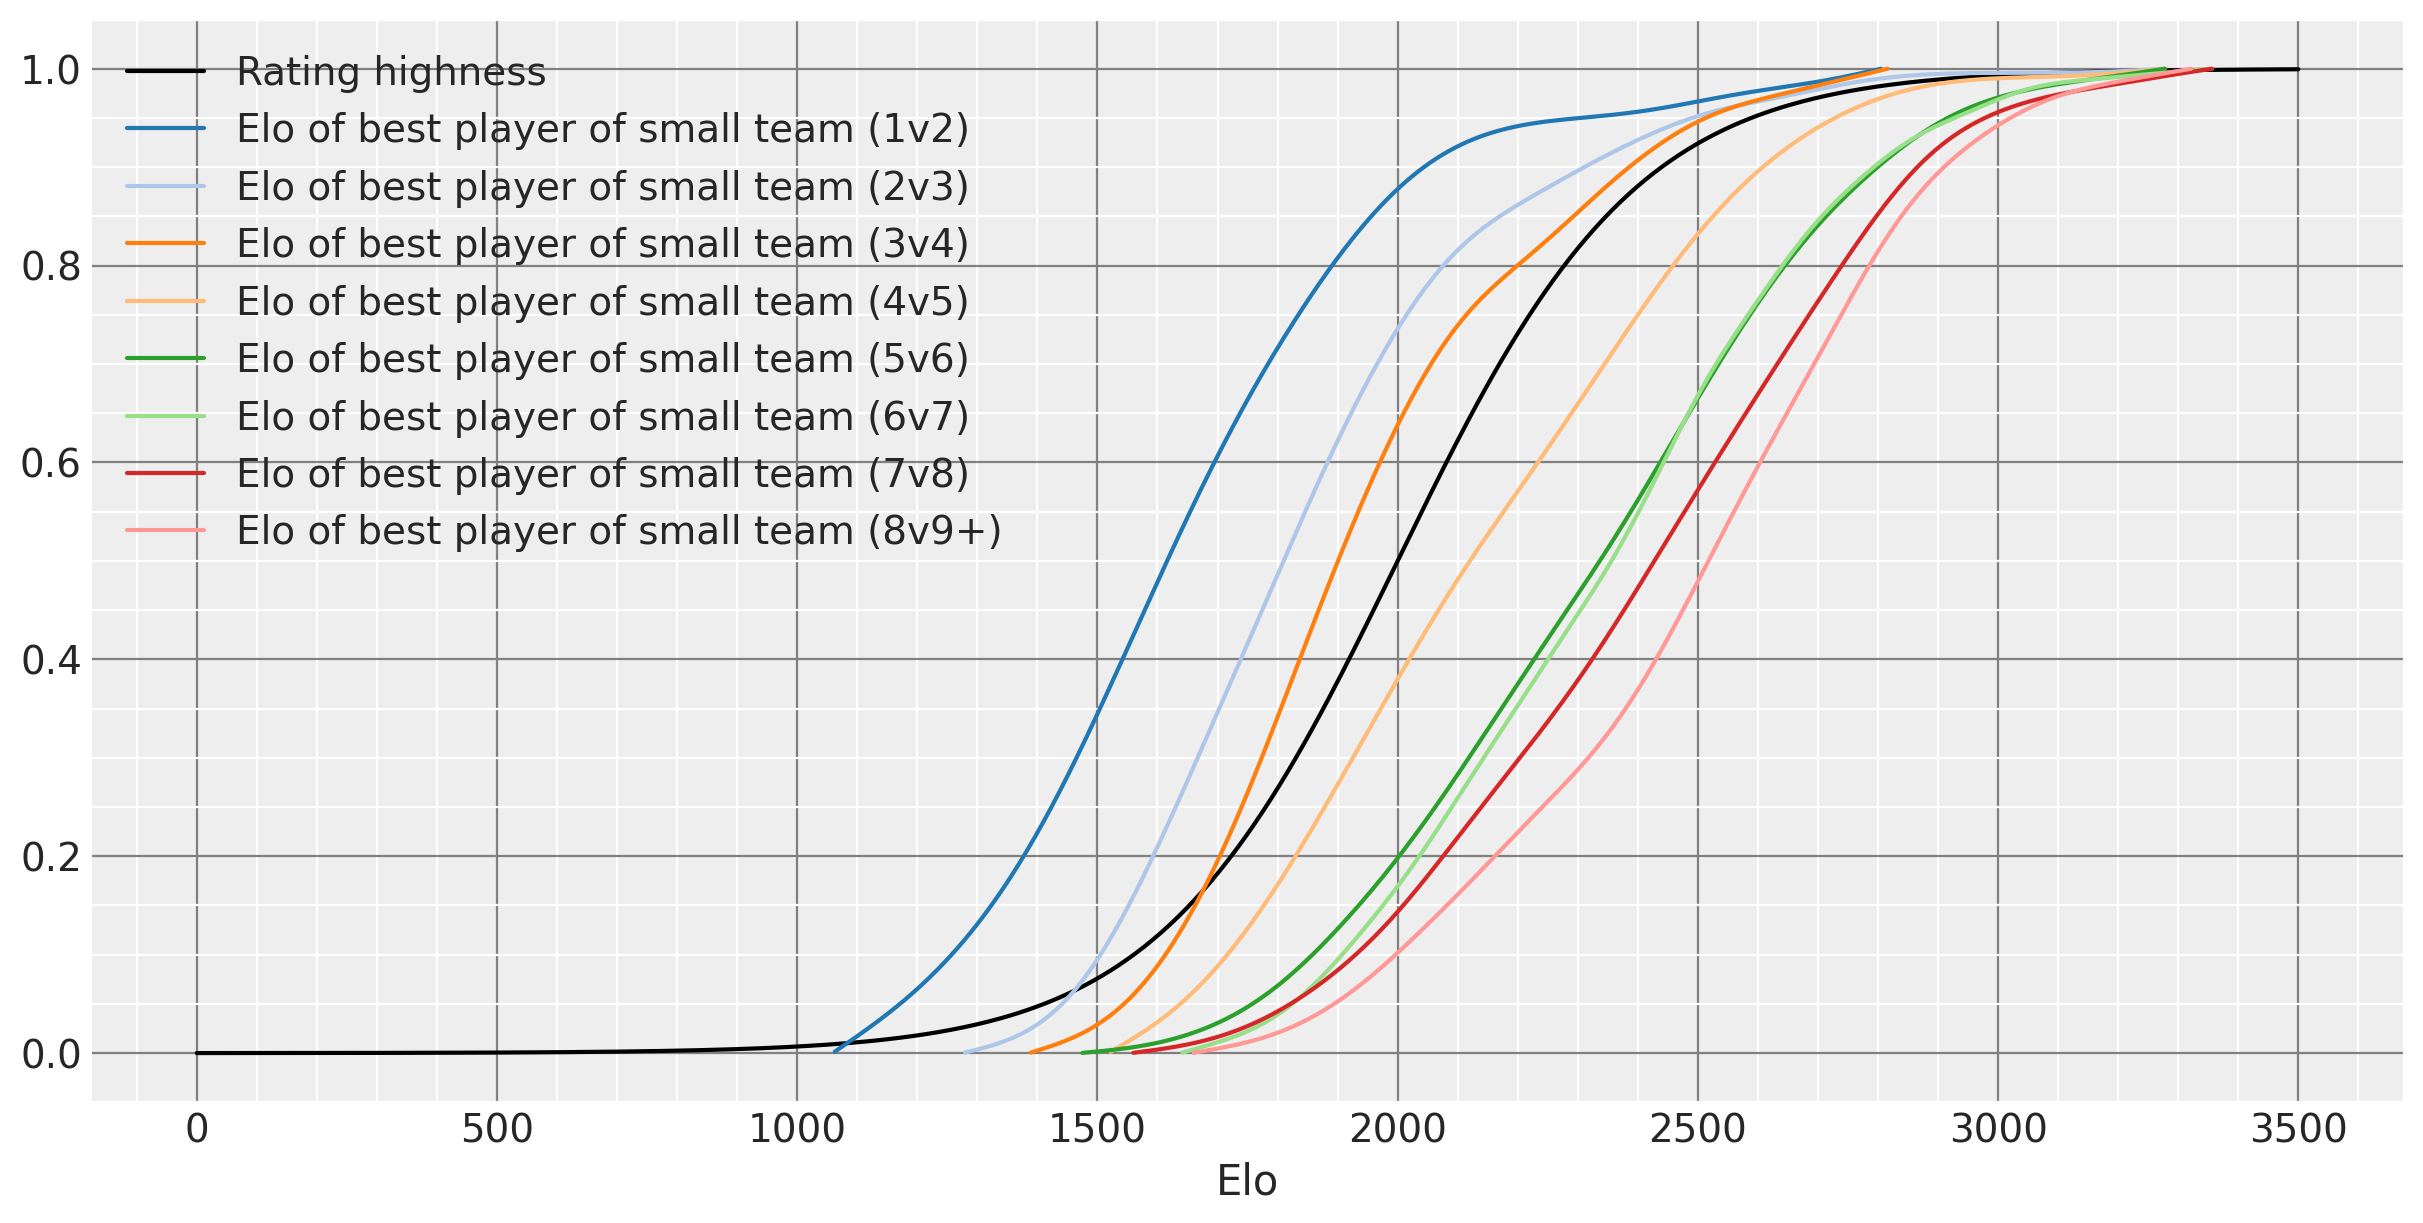

In [11]:
plt.figure(figsize=(12,6))
plt.minorticks_on()
# plt.figure().set_size_inches((15,10))
elos = np.linspace(0, 3500, 500)
# plt.plot(elos, whr.models_shared.eloHighness(models['meanBPST'].idata, elos))
plt.plot(elos, whr.models_shared.eloHighness(frModels['mapBPST'].idata, elos), label='Rating highness', color='black') # Should be the same
plt.xlabel('Elo')
# plt.xticks([2100,2200],minor=True)
plt.grid(which='major',color='gray')
plt.grid(which='minor')

BPST_Elo = whr.getBPSTElo(unevenGamesData, unevenGamesMeanRatings)

for sts in range(1,9):
    ax = az.plot_dist(
        BPST_Elo[unevenGamesData.games.loc[lambda d: d.winnerCount.clip(upper=d.loserCount) == sts].index], 
        cumulative=True, 
        plot_kwargs=dict(label=f'Elo of best player of small team ({whr.advantageClasses[sts-1]})'),
        color=plt.color_sequences['tab20'][sts-1])
plt.legend()
# ax = az.plot_dist(unadjModel.idata.posterior['ratings'].mean(['chain','draw']).pipe(whr.naturalRatingToElo), cumulative=True, ax=ax, color='gray', plot_kwargs=dict(label='All playerDays'))
# ax.axhline(0.5, color='black')

In [12]:
whr.createGameCountByBPSTSummaryTable(unevenGamesData, unevenGamesMeanRatings)

Rating of best player of small team < 1800 Elo       [1800; 2200]        \
                                    ↓ winner ↓         ↓ winner ↓         
                                         Large Small        Large Small   
Size                                                                      
1v2                                         87    28           23    14   
2v3                                         82    31           52    39   
3v4                                         89    34           97    69   
4v5                                         50    23          108    79   
5v6                                         38    12          179   100   
6v7                                         15     5          134    94   
7v8                                         17     9          127    81   
8v9+                                        18    14          298   216   

Rating of best player of small team > 2200 Elo        
                                    ↓ winner ↓        
                                         Large Small  
Size                                                  
1v2                                          5     3  
2v3                                         17    16  
3v4                                         39    36  
4v5                                        115    94  
5v6                                        318   234  
6v7                                        278   177  
7v8                                        307   253  
8v9+                                      1626  1451

# Plots
## Data for plots

In [31]:
from arviz.labels import BaseLabeller, NoModelLabeller
class MyLabeller(NoModelLabeller):
    def make_label_flat(self, var_name: str, sel: dict, isel: dict):
        return self.sel_to_str(sel, isel)

# az.plot_density([idataSimple, idataBPST], var_names='WHR_mult', data_labels=['idataSimple','idataBPST'],hdi_prob=1)

elos=[1600,2400]
# eloLabels = [f'Any Elo\n{elos[0]} Elo'] + [f'{e} Elo' for e in elos[1:]]
eloLabels = [f'{e} Elo' for e in elos]
anyEloLabel = '(Elo-independent)'

def adjustSimpleForDisplay(idata : az.InferenceData, addEloDim : bool):
    x : xa.DataArray = eloPerNaturalRating * idata.posterior['epadc']
    x.name = 'epad'
    return x.expand_dims({'elo':eloLabels}).transpose(...,'elo') if addEloDim else x

def adjustBPSTForDisplay(idata : az.InferenceData):
    x : xa.DataArray = idata.posterior['epadc']
    x.name = 'epad'

    return eloPerNaturalRating * xa.concat([
            (1-t) * x.sel(ratingclass='low rating') + t * x.sel(ratingclass='high rating')
            for e in elos
            for t in [eloHighness(idata, e)]
        ], 
        dim=pd.Index(eloLabels, name='elo')).transpose(...,'elo') #.stack({'cat':['advc','elo']})

simpleModels = [m for m in frModels.values() if m.extraPlayerAdjustment == ExtraPlayerAdvantageType.BY_TEAM_SIZE] + [jointSimpleAdjModel] 
bpstModels = [m for m in frModels.values() if m.extraPlayerAdjustment == ExtraPlayerAdvantageType.BY_TEAM_SIZE_AND_BPST] + [jointBPSTAdjModel]
allModels = simpleModels +  bpstModels

simplePlotData = \
            [adjustSimpleForDisplay(m.idata, False) for m in simpleModels]

allPlotData =  [adjustSimpleForDisplay(m.idata, True) for m in simpleModels] + \
            [adjustBPSTForDisplay(m.idata) for m in bpstModels]

        


## Forest plot

Text(0.5, 0, 'Thin lines: 95% highest density intervals\nThick lines: Interquartile ranges (50% probability)\nDots: Allegedly the means, but might be the medians')

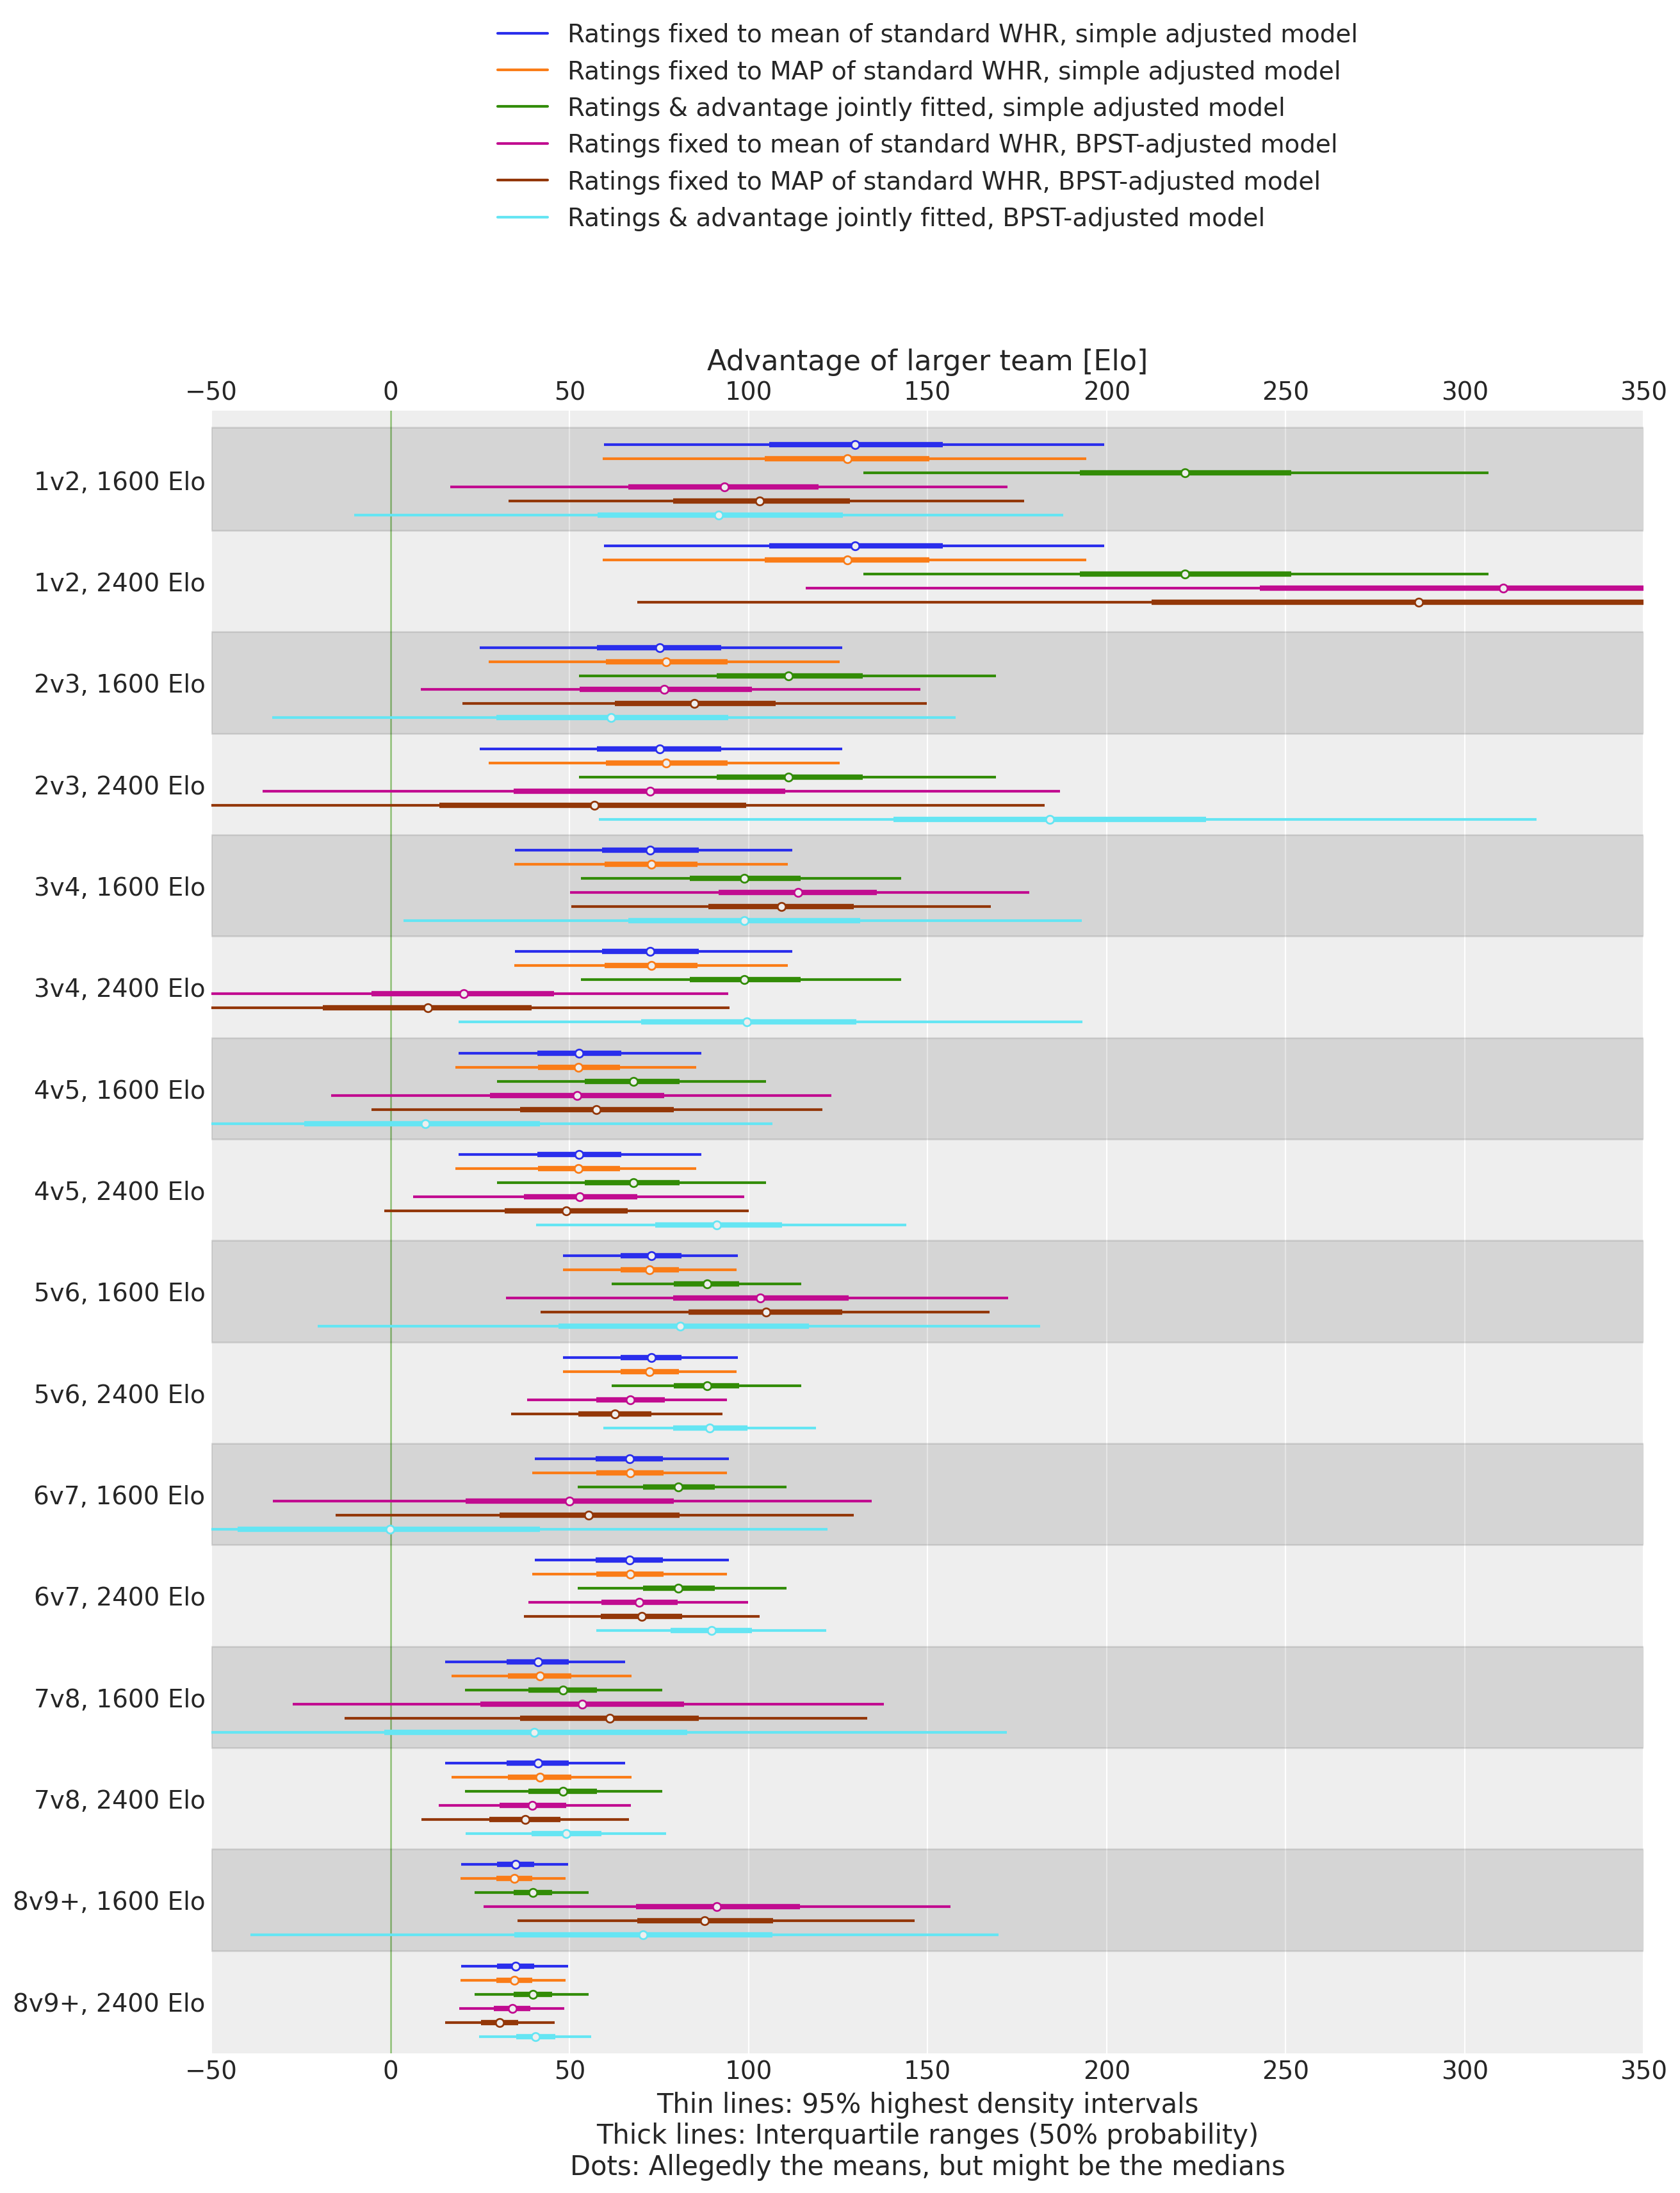

In [30]:
axs = az.plot_forest(allPlotData, model_names=titles(allModels),
    ess=False, combined=True, kind='forestplot',rope=[0,0],
    figsize=(13,17), hdi_prob=0.95,
    labeller=MyLabeller(),
    # coords={'cat' : [ (a,e) for a in whr.advantageClasses for e in [anyEloLabel, *eloLabels]]}
    )

ax : plt.Axes = axs[0]

plt.title('Advantage of larger team [Elo]')

from matplotlib.legend import Legend

l : Legend = ax.get_legend()
texts = l.texts
legendHandles = l.legendHandles
ax.legend(legendHandles[::-1], [t.get_text() for t in texts][::-1], loc='upper center',bbox_to_anchor=(0.5,1.25))

plt.xlim((-50,350))
ylim = plt.ylim()
# plt.ylim((ylim[0],ylim[1]+20))
ax.secondary_xaxis('top')

ax.set_xlabel('Thin lines: 95% highest density intervals\nThick lines: Interquartile ranges (50% probability)\nDots: Allegedly the means, but might be the medians')

# ymtl = ax.get_ymajorticklabels()
# for t in ymtl:
#     t.set_text('foo')
# ax.set_yticklabels(ymtl)

## Density plot

Text(0.5, 0, '$\\uparrow$Different x-axis scale$\\uparrow$')

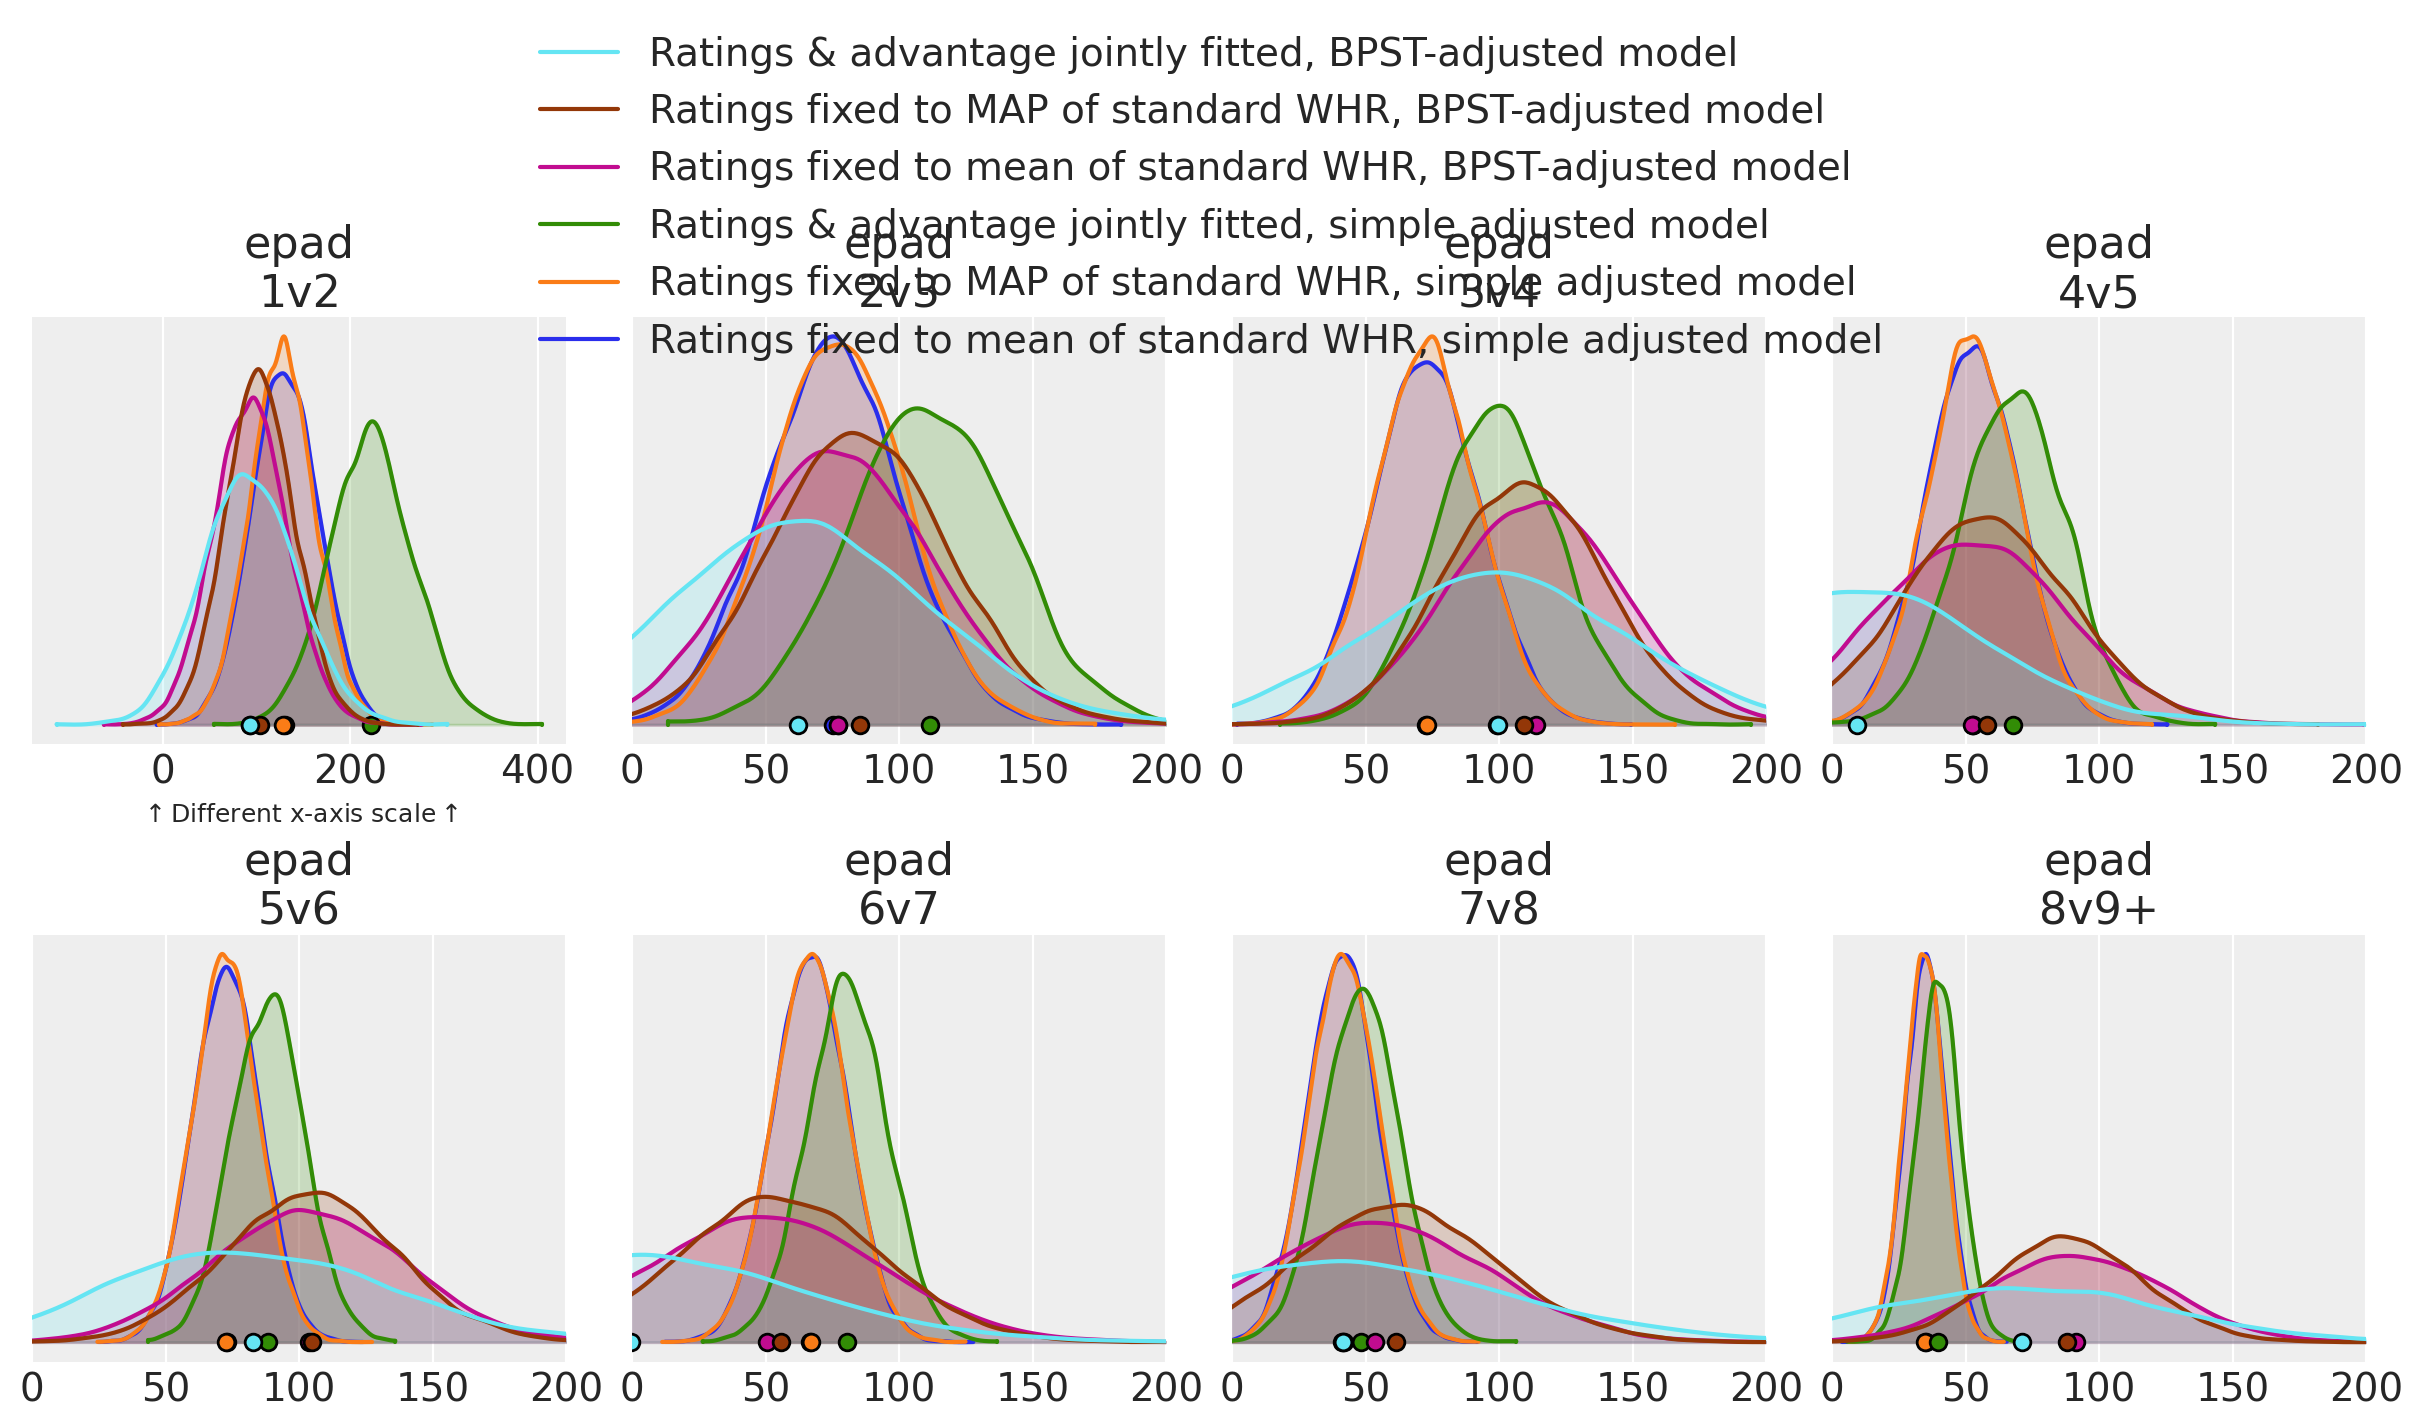

In [37]:
from matplotlib.legend import Legend
fig = plt.figure(figsize=(12,6))
axs = fig.subplots(2,4,
    # sharex=True
    )
    #,gridspec_kw={'top':.8,'bottom':0.2})

az.plot_density([x.sel(elo='1600 Elo') for x in allPlotData], data_labels=titles(allModels),
    # rope=[0,0],
    # figsize=(13,5),
    hdi_prob=1,
    labeller=MyLabeller(),
    show=False,
    # hdi_markers='v', 
    point_estimate='mean',
    # grid=(2,4),
    ax=axs, 
    shade=0.2
    
    )

# axs[1][0].legend([])

whr.postprocess.putLegendOnTopOfFigure(axs[0][0], (.5,1.18))

# axs[0][0].sharex(axs[0][0])

for _, ax in np.ndenumerate(axs):
    if ax != axs[0][0]:
        ax.set_xlim(0,200)

#title('Posterior probability distributions of the advantage of the larger team (in Elo)')
ax : plt.Axes
ax = axs[0][0]
ax.set_xlabel('$\\uparrow$Different x-axis scale$\\uparrow$', size=9)

## Ridge plot

<SecondaryAxis: >

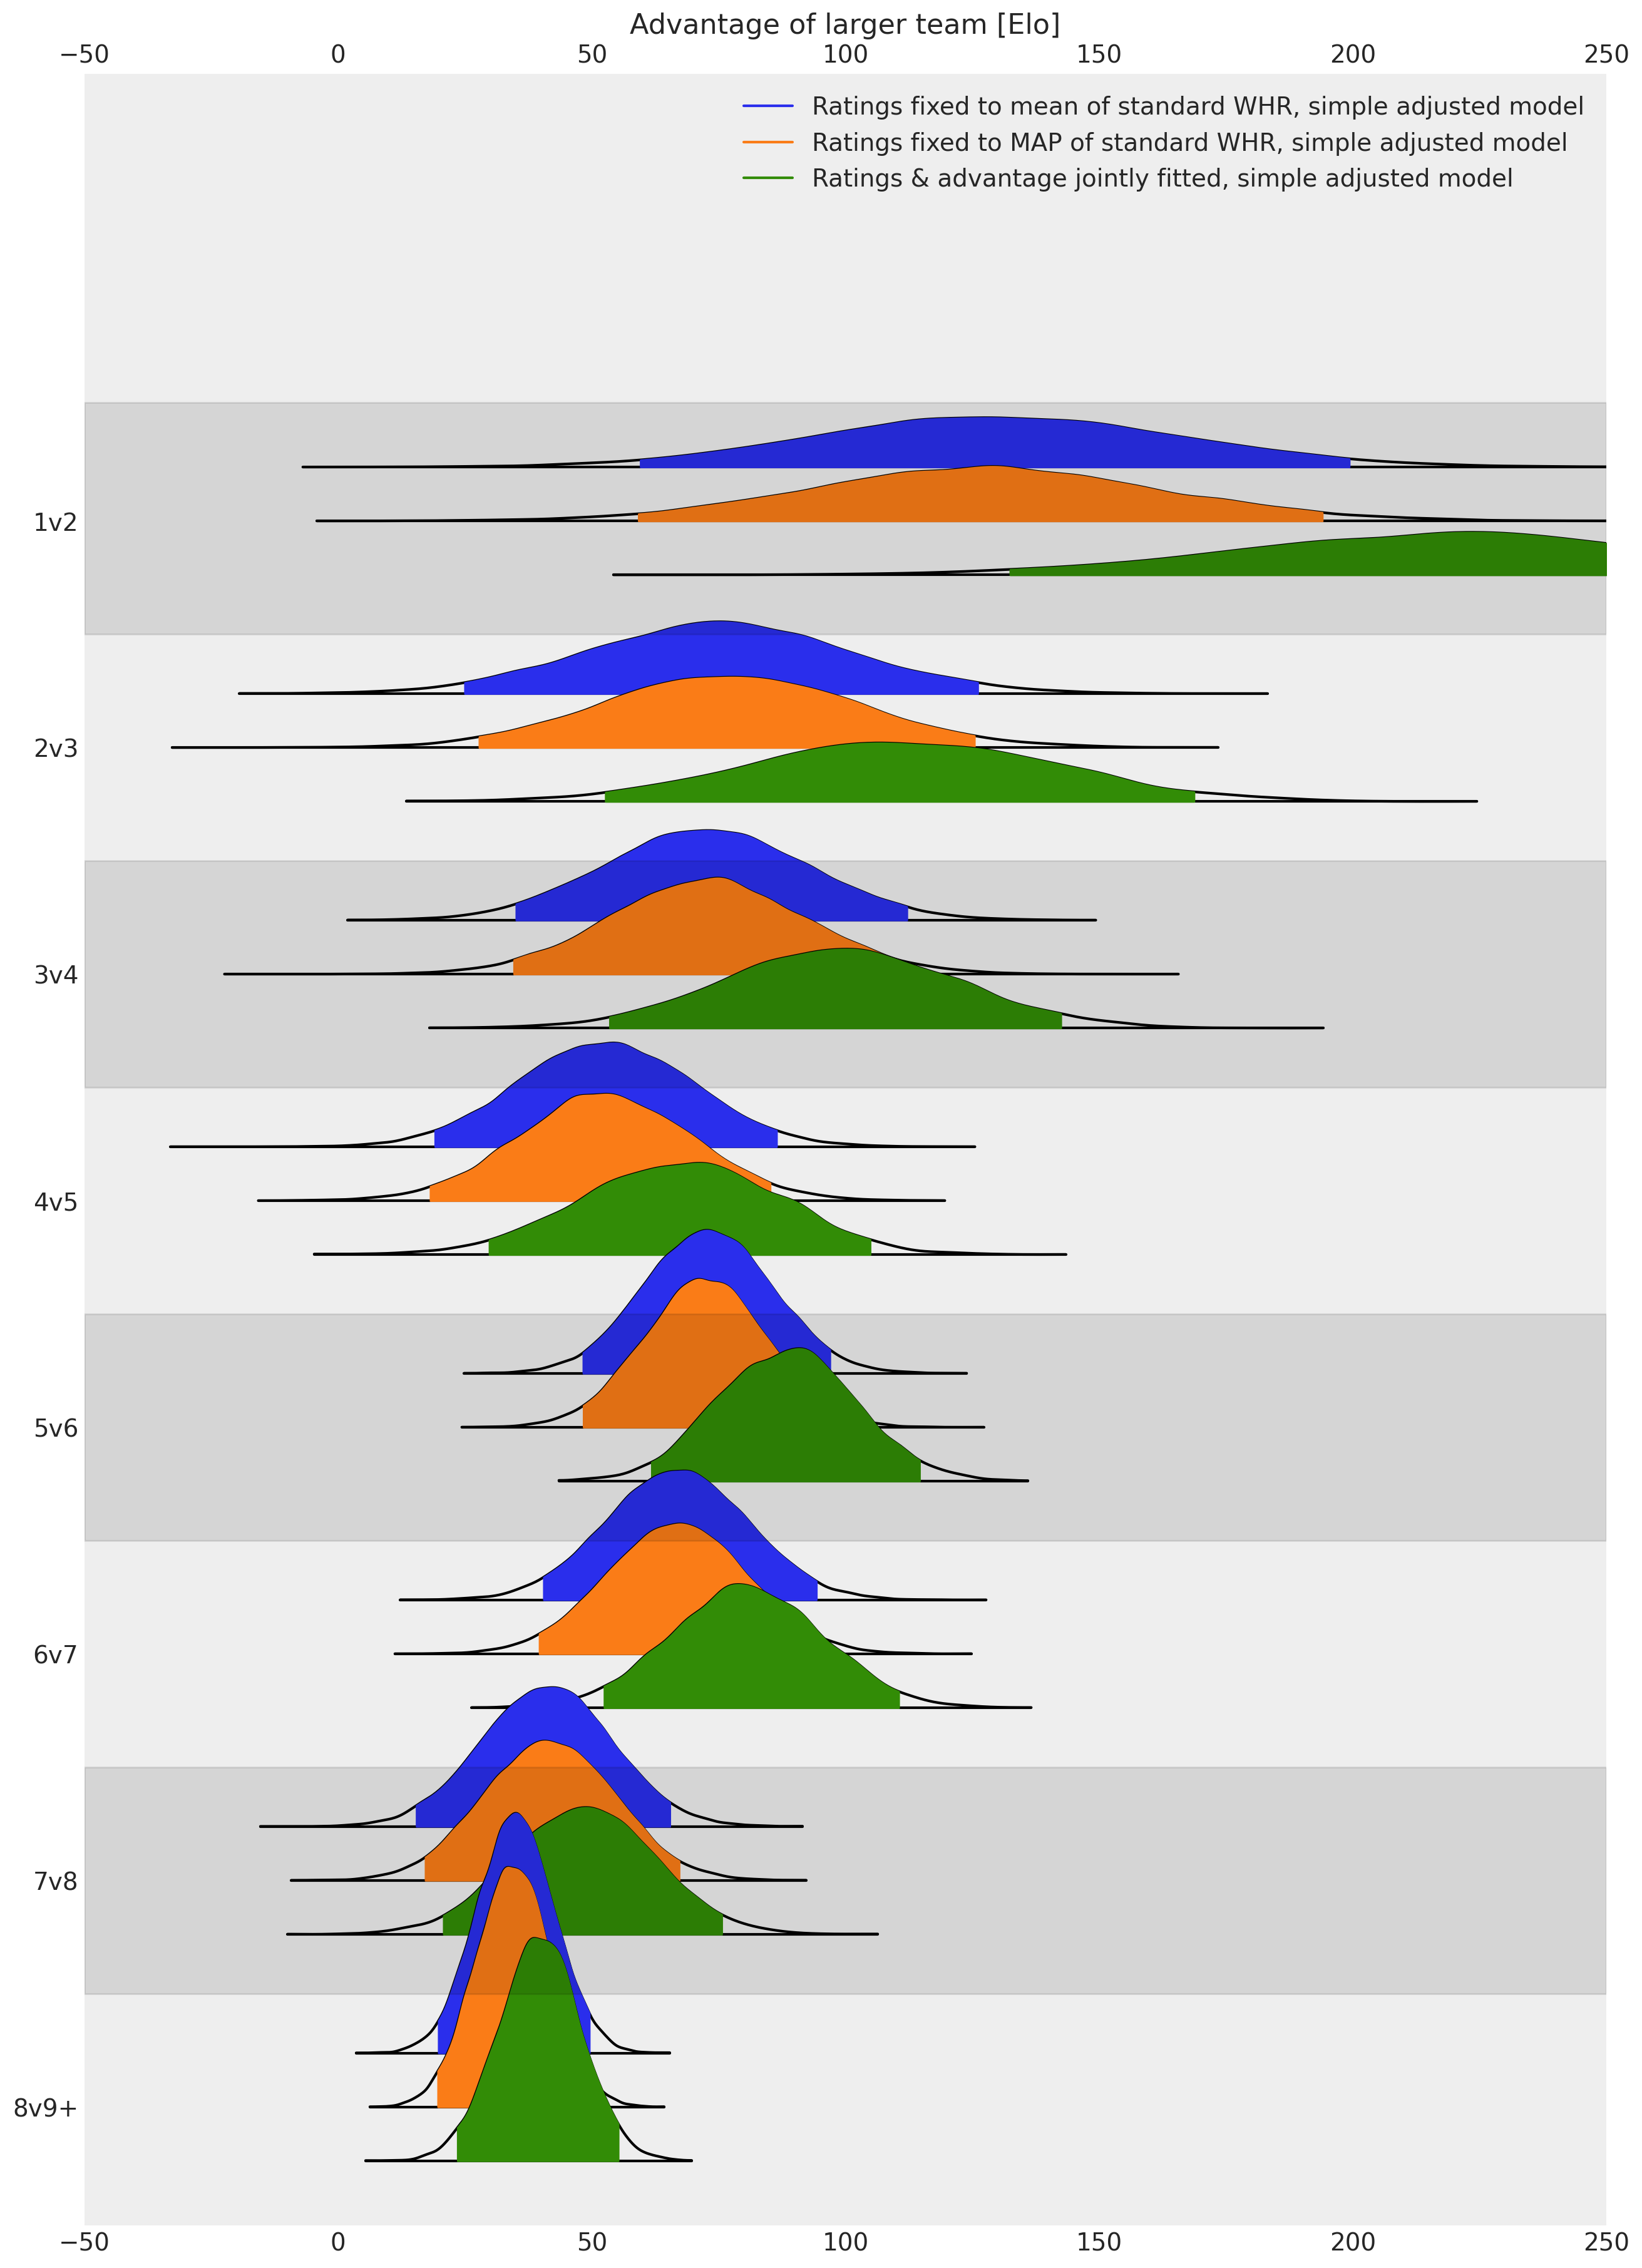

In [34]:
axs = az.plot_forest(simplePlotData, model_names=titles(simpleModels),
    ess=False, combined=True, kind='ridgeplot',rope=[0,0],
    figsize=(13,18), hdi_prob=0.95,
    labeller=MyLabeller(),
    ridgeplot_truncate=False,
    # ridgeplot_alpha=0.5,
    ridgeplot_overlap=1
    # coords={'cat' : [ (a,e) for a in whr.advantageClasses for e in [anyEloLabel, *eloLabels]]}
    )

ax : plt.Axes = axs[0]

plt.title('Advantage of larger team [Elo]')

from matplotlib.legend import Legend

# handles, labels = plt.legend()
l : Legend = ax.get_legend()
texts = l.texts
legendHandles = l.legendHandles
ax.legend(legendHandles[::-1], [t.get_text() for t in texts][::-1], loc='upper right')

plt.xlim((-50,250))
ylim = plt.ylim()
plt.ylim((ylim[0],ylim[1]+0.1))
ax.secondary_xaxis('top')

## Violin plot

In [ ]:
foo = xa.Dataset({f'model{i}' : epad for i, epad in enumerate(simplePlotData)})

In [ ]:
ax = az.plot_violin(foo, grid=(3,8), figsize=(13,8), sharex=False)
# az.plot_violin(plotData[1], ax=ax)

In [ ]:
az.summary(eloPerNaturalRating * (idata.posterior))

In [ ]:
az.summary(eloPerNaturalRating * (idataBPST.posterior['epadc']))

In [ ]:
ratingIxLookup = pat.Series[int](range(len(unevenGamesData.playerDays)), index=unevenGamesData.playerDays.index)

In [ ]:
whr.validateFixedRatingsBPST(frModels['meanBPST'].idata, unevenGamesData, unevenGamesMeanRatings)
whr.validateFixedRatingsBPST(frModels['mapBPST'].idata, unevenGamesData, unevenGamesMAPRatings)

# Model comparison (fixed models)

In [ ]:
for m in frModels.values():
    if not 'log_likelihood' in m.idata:
        with m:
            pm.compute_log_likelihood(m.idata)

for prefix in ('mean','map'):
    cmp = az.compare({ k : m.idata for k,m in frModels.items() if k.startswith(prefix)})
    display(cmp)
    az.plot_compare(cmp)

array([[<AxesSubplot: title={'center': 'epadc\n1v2, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n1v2, high rating'}>,
        <AxesSubplot: title={'center': 'epadc\n2v3, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n2v3, high rating'}>],
       [<AxesSubplot: title={'center': 'epadc\n3v4, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n3v4, high rating'}>,
        <AxesSubplot: title={'center': 'epadc\n4v5, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n4v5, high rating'}>],
       [<AxesSubplot: title={'center': 'epadc\n5v6, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n5v6, high rating'}>,
        <AxesSubplot: title={'center': 'epadc\n6v7, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n6v7, high rating'}>],
       [<AxesSubplot: title={'center': 'epadc\n7v8, low rating'}>,
        <AxesSubplot: title={'center': 'epadc\n7v8, high rating'}>,
        <AxesSubplot: title={'center': 'epadc\n8v9+,

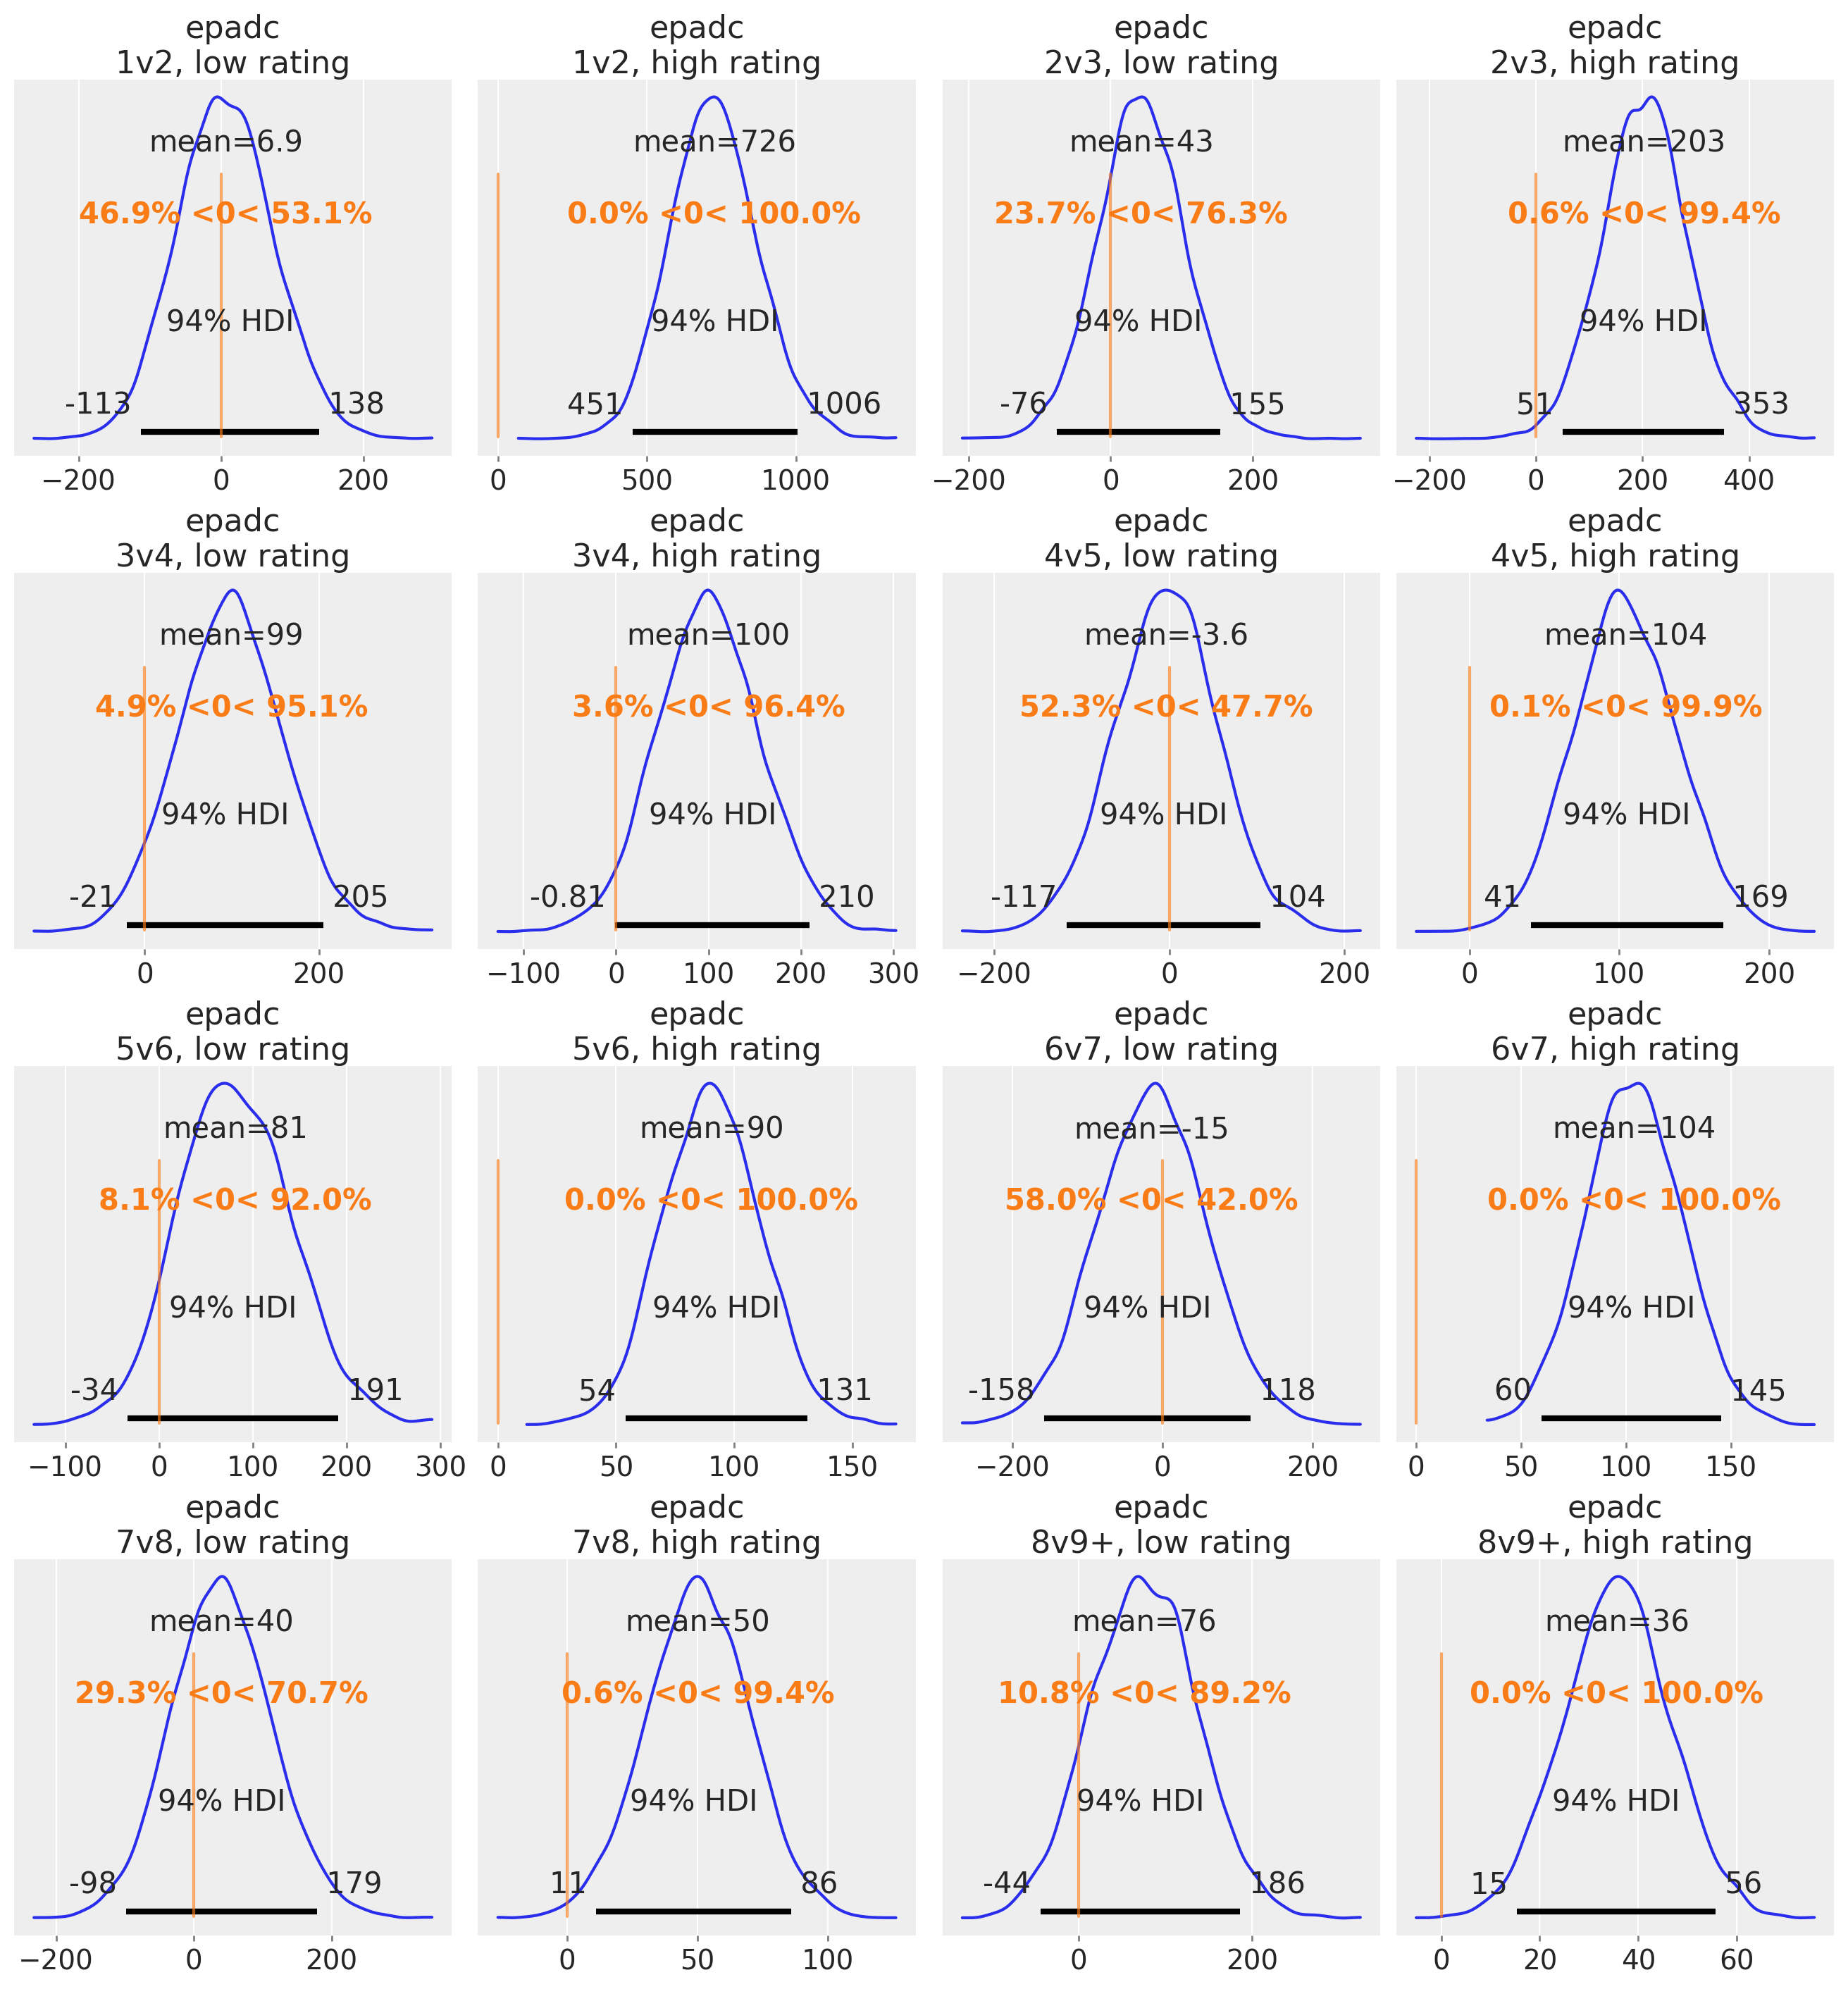

In [27]:
epad = jointBPSTAdjModel.idata.posterior.epadc
# epad = frModels['meanBPST'].idata.posterior.epadc
# az.plot_posterior(eloPerNaturalRating * (epad.sel(ratingclass = 'high rating') - epad.sel(ratingclass = 'low rating')), ref_val=0, figsize=(13,7))
az.plot_posterior(eloPerNaturalRating * epad, ref_val=0, figsize=(13,14))